In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from opacus import PrivacyEngine

In [75]:
#1. Setup Device and Data
device = "cuda" if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor()])
dst = datasets.MNIST("~/.torch", download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dst, batch_size=100, shuffle=True)

In [76]:
# 2. Define LeakyNet (Vulnerable to DLG)
class LeakyNet(nn.Module):
    def __init__(self):
        super(LeakyNet, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(12, 12, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
        )
        self.fc = nn.Linear(12 * 7 * 7, 10)

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

net = LeakyNet().to(device)

In [77]:
# 3. Quick Training (1 Epoch to get realistic weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    loss = F.cross_entropy(net(images), labels)
    loss.backward()
    optimizer.step()
    break # Just one batch for this demo

In [78]:
# 4. Pick a Target Image and Compute Ground Truth Gradient
# Let's take the first image of a new batch
gt_data, gt_label = next(iter(train_loader))
gt_data, gt_label = gt_data[0:1].to(device), gt_label[0:1].to(device)

net.zero_grad()
out = net(gt_data)
y_loss = F.cross_entropy(out, gt_label)
dy_dx = torch.autograd.grad(y_loss, net.parameters())
original_gradient = [g.detach() for g in dy_dx]


In [79]:
# 5. iDLG Label Extraction (Using the last layer gradient sign)
# The index of the most negative gradient sum in the weights of the last layer
last_weight_gradient = original_gradient[-2] 
extracted_label = torch.argmin(torch.sum(last_weight_gradient, dim=1)).item()
print(f"Original Label: {gt_label.item()} | Extracted Label: {extracted_label}")

Original Label: 7 | Extracted Label: 7


In [80]:
# 6. DLG Attack with Dummy Data (Zeros)
dummy_data = torch.zeros(gt_data.size()).to(device).requires_grad_(True)
label_tensor = torch.tensor([extracted_label]).to(device)
attack_optimizer = optim.LBFGS([dummy_data], lr=0.1)

In [81]:
print("Starting DLG Reconstruction...")
for iters in range(150):
    def closure():
        attack_optimizer.zero_grad()
        dummy_out = net(dummy_data)
        dummy_loss = F.cross_entropy(dummy_out, label_tensor)
        dummy_grad = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_grad, original_gradient):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        return grad_diff
    
    attack_optimizer.step(closure)
    if iters % 30 == 0:
        print(f"Iteration {iters}: Loss {closure().item():.8f}")

Starting DLG Reconstruction...
Iteration 0: Loss 0.22746606
Iteration 30: Loss 0.01673516
Iteration 60: Loss 0.00440270
Iteration 90: Loss 0.02206779
Iteration 120: Loss 0.01574170


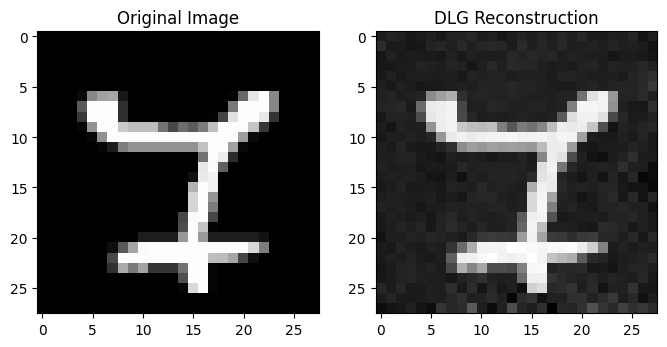

In [82]:
# 7. Visualize Results

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(gt_data.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dummy_data.detach().cpu().squeeze(), cmap='gray')
plt.title("DLG Reconstruction")
plt.show()

# DP defensive 

In [83]:
import torch

def apply_differential_privacy(gradient, noise_multiplier, clipping_threshold):
    # 1. Clip the gradient (Ensuring its norm is <= C)
    # This corresponds to the 'C' in your formula
    grad_norm = torch.norm(gradient)
    clipping_coef = min(1, clipping_threshold / (grad_norm + 1e-6))
    clipped_grad = gradient * clipping_coef
    
    # 2. Calculate the standard deviation of the noise
    # Formula: std = sigma * C
    std_dev = noise_multiplier * clipping_threshold
    
    # 3. Sample noise from Normal Distribution N(0, std^2)
    # This corresponds to the N(0, σ²C²I) part
    noise = torch.randn_like(clipped_grad) * std_dev
    
    # 4. Add the noise to the clipped gradient
    noisy_gradient = clipped_grad + noise
    
    return noisy_gradient

In [84]:
# Initialize the Privacy Engine
privacy_engine = PrivacyEngine()

# Make Private" - This attaches the clipping and noise logic
# target_epsilon: total privacy budget
# target_delta: probability of privacy breach (usually 1/len(dataset))
# max_grad_norm: the 'C' threshold we discussed
model, optimizer, train_loader = privacy_engine.make_private(
    module=net,
    optimizer= optimizer,
    data_loader = train_loader,
    noise_multiplier=1.1, 
    max_grad_norm=1.0, 
)
print(f"Using sigma={optimizer.noise_multiplier} and C={optimizer.max_grad_norm}")


Using sigma=1.1 and C=1.0


In [85]:

# 1. Setup Data and Vulnerable Model
device = "cpu"
dst = datasets.MNIST("~/.torch", download=True, train=True, transform=transforms.ToTensor())
net = LeakyNet().to(device) # Using the LeakyNet we defined earlier

# Pick the first image
gt_data, gt_label = dst[0]
gt_data = gt_data.unsqueeze(0).to(device)
gt_label = torch.tensor([gt_label]).to(device)

# 2. Extract Clean Gradients
out = net(gt_data)
y_loss = F.cross_entropy(out, gt_label)
dy_dx = torch.autograd.grad(y_loss, net.parameters())


Attacking DP-protected gradients...


<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_125499/2588344252.py:41: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"DP Reconstruction\n($\sigma$={noise_multiplier}, C={clipping_threshold})")


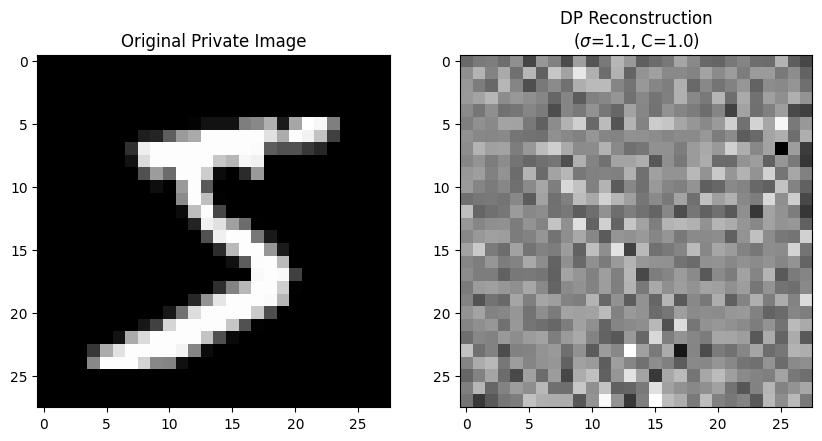

In [86]:

# 3. Apply your DP function to each layer
# We'll use a sigma of 1.1 and C of 1.0 for strong defense
noise_multiplier = 1.1
clipping_threshold = 1.0

dp_gradients = [
    apply_differential_privacy(g.detach().clone(), noise_multiplier, clipping_threshold) 
    for g in dy_dx
]

# 4. iDLG Label Extraction (even with noise, labels are often leakable)
last_weight_gradient = dp_gradients[-2]
extracted_label = torch.argmin(torch.sum(last_weight_gradient, dim=1)).item()

# 5. DLG Attack on DP-Protected Gradients
dummy_data = torch.zeros(gt_data.size()).requires_grad_(True)
optimizer = torch.optim.LBFGS([dummy_data], lr=0.1)

print("Attacking DP-protected gradients...")
for i in range(100):
    def closure():
        optimizer.zero_grad()
        dummy_out = net(dummy_data)
        dummy_loss = F.cross_entropy(dummy_out, torch.tensor([extracted_label]))
        dummy_grad = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        # Match dummy gradients to the NOISY DP gradients
        grad_diff = sum(((gx - gy)**2).sum() for gx, gy in zip(dummy_grad, dp_gradients))
        grad_diff.backward()
        return grad_diff
    optimizer.step(closure)

# 6. Compare Original vs. Reconstructed
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gt_data.detach().cpu().squeeze(), cmap='gray')
plt.title("Original Private Image")

plt.subplot(1, 2, 2)
plt.imshow(dummy_data.detach().cpu().squeeze(), cmap='gray')
plt.title(f"DP Reconstruction\n($\sigma$={noise_multiplier}, C={clipping_threshold})")
plt.show()